# Live Transcriber (sounddevice version)
This script is for finding the Scarlett and recording audio from it. It will then transcribe the audio and save the text to a csv file in real time.

It also implements multithreading so that the recording and transcription can happen simultaneously.


# Game Plan
- Only one recording thread. The thread is continuously listening and internally checks if each channel is speaking, with speaker status being independent between the channels. 
- At the end of a chunk on a given channel, the accumulated recording is then sent to a transcriber thread. 
- So, at any given time, only one recording thread is activated while a number of transcriber threads can be operating. 
- ThreadLock will be used to save data to .csv. 

In [6]:
import wave
import audioop
import os
import pandas as pd
import numpy as np
import time as tm
import whisper
from transcriber import transcribe
import threading
from pathlib import Path
import queue
import sounddevice as sd
from scipy.io.wavfile import write
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

In [7]:
#find the Scarlett
devices = sd.query_devices()
device_index = None
for i, device_info in enumerate(devices):
    if "Scarlett" in device_info["name"] and device_info["max_input_channels"] > 0:
        device_index = i
        break

if device_index is None:
    raise RuntimeError("Could not find Scarlett device")
else:
    print(f'Using device {device_index}: {devices[device_index]["name"]}')

Using device 1: Scarlett 2i2 USB


In [18]:
CHANNELS = 2
global RATE
RATE = 16000
#global CHUNK
#CHUNK = 400
global BLOCKSIZE
BLOCKSIZE = 400
THRESHOLD = 0.001  # Adjust this value based on your microphone and environment
AUDIOFILE_PATH = '/Users/f004swn/Dropbox (Dartmouth College)/scrap_hack/ArtsIntegrationHack/scripts/audio_outputs'
GAP = 2 # Length of silence allowed before cut
SESSION_TIME = 3 # number of mins the session can be
AUDIOFILE_PATH = '/Users/f004swn/Dropbox (Dartmouth College)/scrap_hack/ArtsIntegrationHack/scripts/audio_outputs'
SESSION_ACTIVE = True
MINIMUM_UTTERANCE_LENGTH = 1 # in seconds

In [13]:
transcripts = {}
global transcription_queue
transcription_queue = queue.Queue()

# Setting up the callback
The `sounddevice` library can record by passing a callback function to the `sd.InputStream` stream. It is in the callback that you are doing the listening, speaking status detection, and writing of data. This will run continuously and pass chunks of audio to the transriber threads, which handle transcription and saving of the audio and text.

In [14]:
def rms(data):
    return np.sqrt(np.mean(np.square(data)))

In [26]:
class RecorderThread(threading.Thread):
    def __init__(self):
        super(RecorderThread, self).__init__()
        self.channel1_recording, self.channel2_recording = False, False
        self.ch1_data, self.ch2_data = np.array([]), np.array([])
        self.ch1_last, self.ch2_last = tm.time(), tm.time()
        self.ch1_start, self.ch2_start = None, None

    def record_dyad(self, indata, frames, time, status=None):
        # Get channel data and calulate RMS for each channel separately
        channel1_rms, channel2_rms = rms(indata[:, 0]), rms(indata[:, 1])

        # channel 1 control block
        if channel1_rms > THRESHOLD:
            if self.channel1_recording == False:
                print('channel 1 recording')
                self.ch1_last = tm.time()
                self.channel1_recording = True
                self.ch1_start = tm.time()
                self.ch1_data = np.concatenate((self.ch1_data, indata[:, 0]))
            else:
                self.ch1_last = tm.time()
                self.ch1_data = np.concatenate((self.ch1_data, indata[:, 0]))
        else:
            if self.channel1_recording == True:
                if (tm.time() - self.ch1_last > GAP):
                    self.channel1_recording = False
                    packet = {'channel': 1, 'data': self.ch1_data, 'start_time': self.ch1_start, 'end_time': self.ch1_last}
                    self.ch1_data = np.array([])
                    transcription_queue.put(packet)
                    self.ch1_start, self.ch1_last = None, None
            else:
                pass

        # channel 2 control block
        if channel2_rms > THRESHOLD:
            if self.channel2_recording == False:
                print('channel 2 recording')
                self.ch2_last = tm.time()
                self.channel2_recording = True
                self.ch2_start = tm.time()
                self.ch2_data = np.concatenate((self.ch2_data, indata[:, 1]))
            else:
                self.ch2_last = tm.time()
                self.ch2_data = np.concatenate((self.ch2_data, indata[:, 1]))
        else:
            if self.channel2_recording == True:
                if (tm.time() - self.ch2_last > GAP):
                    self.channel2_recording = False
                    packet = {'channel': 2, 'data': self.ch2_data, 'start_time': self.ch2_start, 'end_time': self.ch2_last}
                    self.ch2_data = np.array([])
                    transcription_queue.put(packet)
                    self.ch2_start, self.ch2_last = None, None
            else:
                pass

    def run(self):
        with sd.InputStream(channels=CHANNELS, device=device_index, callback=self.record_dyad, blocksize=BLOCKSIZE, samplerate=RATE):
            while True:
                # run until the session is over
                if SESSION_ACTIVE == False:
                    print('session over')       
                    break

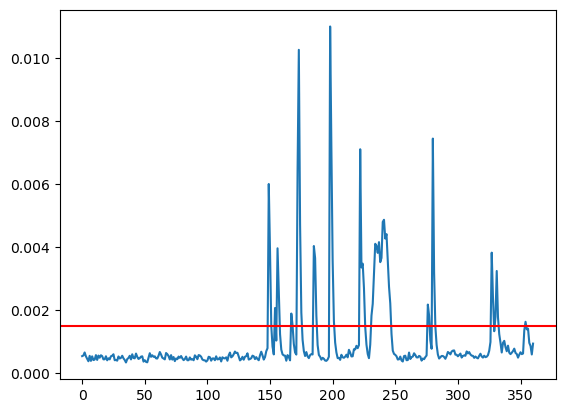

In [17]:
# record from channel 1 for 10 seconds to get rms values and then visualize them
rms_vals = []
start = tm.time()
with sd.InputStream(channels=CHANNELS, device=device_index, blocksize=BLOCKSIZE, samplerate=RATE) as stream:
    while True:
        data = stream.read(400)[0]
        data = data[:, 1]
        rms_val = rms(data)
        rms_vals.append(rms_val)
        if tm.time() - start > 10:
            break

plt.plot(rms_vals)
# plot a horizontal line at the threshold value
plt.axhline(y=0.0015, color='r', linestyle='-')

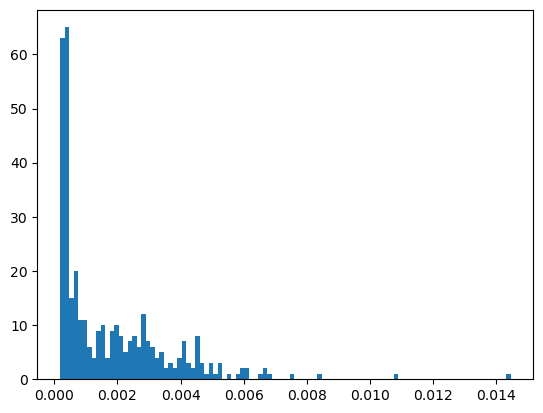

In [8]:
plt.hist(rms_vals, bins=100);

In [27]:
global n_utterances
n_utterances = 0
def process_transcription(data_dict):
    # do nothing if the audio is too short
    global n_utterances
    n_utterances += 1
    # save audio file to disk
    filename = f'utterance_{n_utterances}.wav'
    filepath = os.path.join(AUDIOFILE_PATH, filename)
    write(filepath, RATE, data_dict['data'])
    data_dict['filepath'] = filepath
    transcription = transcribe(filepath)
    data_dict['transcription'] = transcription
    # delete the audio data from the data_dict
    del data_dict['data']
    return n_utterances, data_dict

In [29]:

# Function that will process the data
def transcribe_data():
    while True:
        # Get data from the queue, block if necessary until an item is available
        utterance_dict = transcription_queue.get()
        if utterance_dict is None:
            continue  # None is the signal to stop

        
        out = process_transcription(utterance_dict)
        if out is None:
            continue
        else:
            utter_n, utterance_info = out
        print(utterance_info['transcription'])
        transcripts[utter_n] = utterance_info

        # Signal that the task is done
        transcription_queue.task_done()

SESSION_ACTIVE = True

# Number of worker threads
num_worker_threads = 3

# Create and start the data processing threads
workers = []
for i in range(num_worker_threads):
    t = threading.Thread(target=transcribe_data)
    t.start()
    workers.append(t)

recorder = RecorderThread()
recorder.start()

# wait 30 seconds then stop all the threads
print('Session started, begin sleeping.')
tm.sleep(30)
print('Ending session.')
SESSION_ACTIVE = False
recorder.join()
for t in tqdm(workers):
    t.join()
    
# # Once done collecting data, join on the queue to allow processing to finish
# data_queue.join()

# # Stop the worker threads by putting None into the queue for each worker
# for i in range(num_worker_threads):
#     data_queue.put(None)
# for t in workers:
#     t.join()


Session started, begin sleeping.
channel 1 recording
channel 2 recording
channel 2 recording
channel 2 recording


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/f004swn/anaconda3/envs/scrap_hack/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/f004swn/anaconda3/envs/scrap_hack/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/l2/ydrm4wvj4fv10hb243tjbs0c0000gn/T/ipykernel_71259/1695041775.py", line 10, in transcribe_data
  File "/var/folders/l2/ydrm4wvj4fv10hb243tjbs0c0000gn/T/ipykernel_71259/3766282363.py", line 12, in process_transcription
  File "/Users/f004swn/Dropbox (Dartmouth College)/scrap_hack/ArtsIntegrationHack/scripts/transcriber.py", line 24, in transcribe
    result = whisper.decode(model, mel, options)
  File "/Users/f004swn/anaconda3/envs/scrap_hack/lib/python3.8/site-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "/Users/f004swn/anaconda3/envs/scrap_hack/lib/python3.8/site-packages/whispe

testing testing


KeyboardInterrupt: 

In [10]:
# clear the queue 
while not transcription_queue.empty():
    transcription_queue.get()
    transcription_queue.task_done()

In [30]:
transcription_queue.empty()

True

channel 2 recording
Why is this happening?


In [31]:
transcripts

{2: {'channel': 2,
  'start_time': 1699279901.775316,
  'end_time': 1699279901.775312,
  'filepath': '/Users/f004swn/Dropbox (Dartmouth College)/scrap_hack/ArtsIntegrationHack/scripts/audio_outputs/utterance_1.wav',
  'transcription': 'testing testing'},
 3: {'channel': 2,
  'start_time': 1699279912.775713,
  'end_time': 1699279912.775711,
  'filepath': '/Users/f004swn/Dropbox (Dartmouth College)/scrap_hack/ArtsIntegrationHack/scripts/audio_outputs/utterance_3.wav',
  'transcription': 'Why is this happening?'}}

channel 2 recording
you
channel 2 recording
channel 2 recording


Exception in thread Thread-13:
Traceback (most recent call last):
  File "/Users/f004swn/anaconda3/envs/scrap_hack/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/f004swn/anaconda3/envs/scrap_hack/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/l2/ydrm4wvj4fv10hb243tjbs0c0000gn/T/ipykernel_71259/1016251939.py", line 10, in transcribe_data
  File "/var/folders/l2/ydrm4wvj4fv10hb243tjbs0c0000gn/T/ipykernel_71259/3766282363.py", line 12, in process_transcription
  File "/Users/f004swn/Dropbox (Dartmouth College)/scrap_hack/ArtsIntegrationHack/scripts/transcriber.py", line 24, in transcribe
    result = whisper.decode(model, mel, options)
  File "/Users/f004swn/anaconda3/envs/scrap_hack/lib/python3.8/site-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "/Users/f004swn/anaconda3/envs/scrap_hack/lib/python3.8/site-packages/whisp

Thank you.
channel 2 recording


In [33]:
# stop the recorder thread
recorder.join()

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/Users/f004swn/anaconda3/envs/scrap_hack/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/f004swn/anaconda3/envs/scrap_hack/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/l2/ydrm4wvj4fv10hb243tjbs0c0000gn/T/ipykernel_71259/2847660656.py", line 10, in transcribe_data
  File "/var/folders/l2/ydrm4wvj4fv10hb243tjbs0c0000gn/T/ipykernel_71259/3766282363.py", line 12, in process_transcription
  File "/Users/f004swn/Dropbox (Dartmouth College)/scrap_hack/ArtsIntegrationHack/scripts/transcriber.py", line 24, in transcribe
    result = whisper.decode(model, mel, options)
  File "/Users/f004swn/anaconda3/envs/scrap_hack/lib/python3.8/site-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "/Users/f004swn/anaconda3/envs/scrap_hack/lib/python3.8/site-packages/whispe

See you next time!
See you next time!


KeyboardInterrupt: 

channel 2 recording


In [10]:
# record for 10 seconds and try to transcribe
recording = np.array([])
start = tm.time()
with sd.InputStream(channels=CHANNELS, device=device_index, blocksize=BLOCKSIZE, samplerate=RATE) as stream:
    while True:
        data = stream.read(400)[0]
        data = data[:, 0]
        recording = np.concatenate((recording, data))

        if tm.time() - start > 10:
            break

filename = 'test_utt.wav'
filepath = os.path.join(AUDIOFILE_PATH, filename)
write(filepath, RATE, recording)
t_start = tm.time()
transcription = transcribe(filepath)
t_end = tm.time()
print(f'Transcription: {transcription}')
print(f'Took {t_end - t_start} seconds to transcribe')

Transcription: Just testing if this actually works. I just want to see if this works. I love coffee. I love hamburgers, etc.
Took 1.2383301258087158 seconds to transcribe
